# Preprocessing Data with Scanpy 1.8 - Part II #
## Load packages ##

In [1]:
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi

STUD_PATH = '/mnt/workspace_stud/'
OUTPUT_PATH = f'{STUD_PATH}stud5/output/'
GTF_PATH = f'{STUD_PATH}mbentse/homo_sapiens/homo_sapiens.104.mainChr.gtf'

In [18]:
#INPUT_PATH = f'{OUTPUT_PATH}complete_liver_clpp17.h5ad'
#INPUT_PATH = f'{OUTPUT_PATH}complete_liver_clpp17_mc10.h5ad'
INPUT_PATH = f'{OUTPUT_PATH}complete_liver_clpp17_Z9a.h5ad'
TISSUE = INPUT_PATH.split('/')[-1].replace('_clpp17.h5ad', '')
TSV_OUT = f"{OUTPUT_PATH}clusters_{TISSUE}.tsv"
output_wp4 = f"{OUTPUT_PATH}wp4/{TISSUE}_obs.csv"
output_wp3 = f"{OUTPUT_PATH}wp3/clusters_{TISSUE}.tsv"
output_sc_csv = f"{OUTPUT_PATH}wp1/scanpy.csv"

## Read input file(s) ##

In [3]:
adata = ad.read(INPUT_PATH)
adata

AnnData object with n_obs × n_vars = 185734 × 503863
    obs: 'batch', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary', 'normalised'

## Preprocessing ##

In [4]:
epi.pp.log1p(adata)

### Calculate neighbors and clusters ###

In [5]:
#epi.pp.lazy(adata, min_dist=1.0, spread=2.0)
sc.pp.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')

### Clustering ###
Choosing parameters as listed:
- min_disst = 0.1
- spread = 2.0
- no_weights
- resolution = 0.7

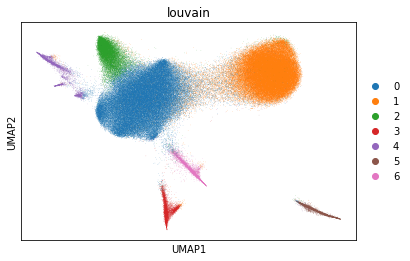

In [6]:
# min_dist=0.1, spread=2.0
sc.tl.umap(adata, 0.1, 2.0)

# no weights, resolution=0.7
epi.tl.louvain(adata, resolution=0.7)
epi.pl.umap(adata, color=['louvain'], wspace=0.4)

### Write files for WP3/4 ###
#### Write out cluster files ####

In [7]:
#with open(output_wp4, "w") as obs_file, open(output_wp3, "w") as tsv_file:
#    line = "barcode\tcluster\n"
#    obs_file.write(line)
#    tsv_file.write(line)
#    for barcode in range(len(adata.obs.index)):
#        line = f"{adata.obs.index[barcode]}\t{adata.obs['louvain'][barcode]}\n"
#        obs_file.write(line)
#        tsv_file.write(line)

#### Write out bed files ####

In [8]:
#for cluster in adata.obs['louvain'].unique():
#    cluster_adata = adata[adata.obs['louvain'] == cluster]
#    epi.pp.filter_features(cluster_adata, min_cells=1)
#    cluster_path = f'{OUTPUT_PATH}wp1/{TISSUE}_cluster_{cluster}.bed'
#    with open(cluster_path, 'w') as cl_output:
#        for peak in cluster_adata.var.index:
#            tmp = peak.replace('_', '\t')
#            cl_output.write(f"{tmp}\n")

## Gene Annotation ##
### Find & Rank Genes/Features ###

In [9]:
epi.tl.find_genes(adata,
           gtf_file=GTF_PATH,
           key_added='gene_annotation',
           upstream=10000,
           feature_type='gene',
           annotation='havana',
           raw=False)

adata.var['gene_annotation']

chr1_79215_79615                                            intergenic
chr1_102755_103155                                          intergenic
chr1_276109_276509                                          intergenic
chr1_631178_631578        MTCO1P12;MTATP6P1;MTCO2P12;MTATP8P1;MTCO3P12
chr1_794897_795297                                           LINC01409
                                              ...                     
chrY_20699407_20699807                                      intergenic
chrY_20828004_20828404                                      intergenic
chrY_20828469_20828869                                      intergenic
chrY_20997429_20997829                                      intergenic
chrY_21021910_21022310                                      unassigned
Name: gene_annotation, Length: 503863, dtype: object

### Filter unassigned / intergenic features ###

In [10]:
assigned_features = adata.var[adata.var['gene_annotation'] != "intergenic"]
assigned_features = assigned_features[assigned_features['gene_annotation'] != "unassigned"]
assigned_adata = adata[:, assigned_features.index]

assigned_adata

View of AnnData object with n_obs × n_vars = 185734 × 72595
    obs: 'batch', 'nb_features', 'louvain'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'gene_annotation'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

### Replace peaks with gene names ###

In [11]:
names = []

for n in assigned_adata.var['gene_annotation'].values:
    #n = n.split(';')
    #names.append(n[0])
    names.append(n)
    
assigned_adata.var_names = pd.Index(names)

- make new feature names unique and write them into raw

In [12]:
assigned_adata.var_names_make_unique(join="_")
assigned_adata.raw = assigned_adata

### Rank genes ###

... storing 'gene_annotation' as categorical


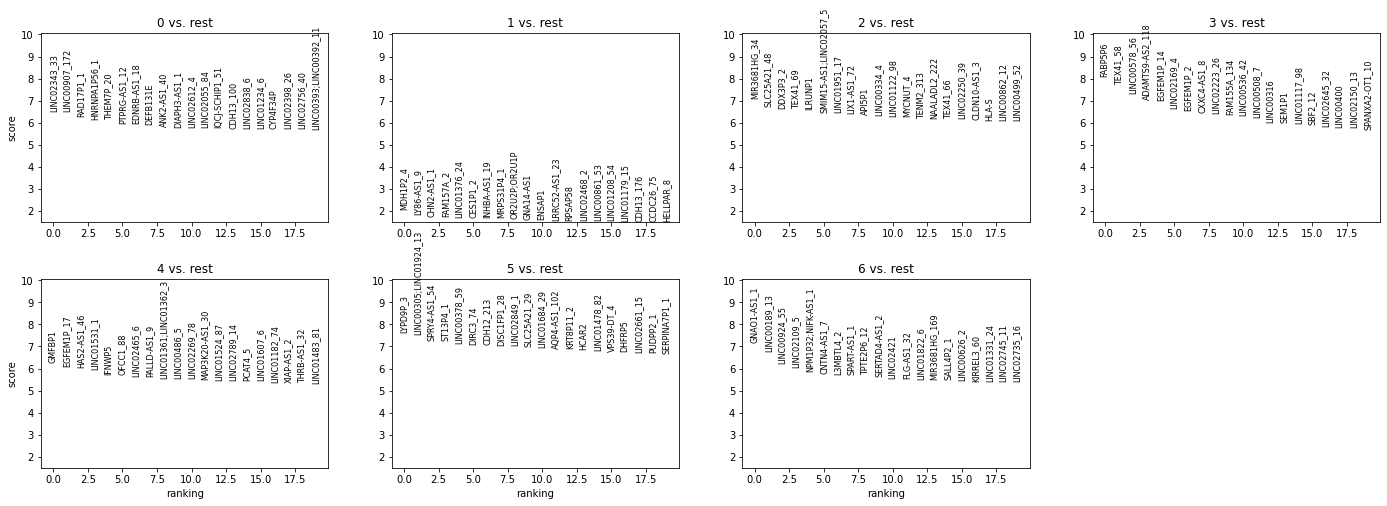

In [13]:
sc.tl.rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
#sc.tl.filter_rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(assigned_adata)

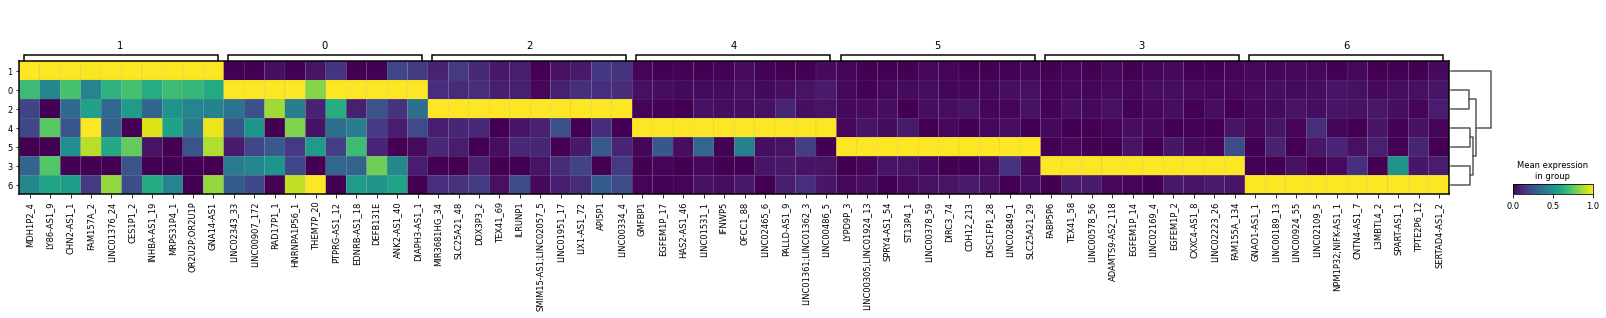

In [14]:
sc.pl.rank_genes_groups_matrixplot(assigned_adata, standard_scale='var', n_genes=10)

## Preparing for celltyp annotation ##
#### Remove marker gene count (gene_count --> gene) ####

In [15]:
result = assigned_adata.uns['rank_genes_groups']
for i, name_list in enumerate(result['names']):
    for j, name_string in enumerate(name_list):
        result['names'][i][j] = name_string.split('_')[0]

pd.DataFrame(result['names'])

,0,1,2,3,4,5,6
0,LINC02343,MDH1P2,MIR3681HG,FABP5P6,GMFBP1,LYPD9P,GNAO1-AS1
1,LINC00907,LY86-AS1,SLC25A21,TEX41,EGFEM1P,LINC00305;LINC01924,LINC00189
2,RAD17P1,CHN2-AS1,DDX3P3,LINC00578,HAS2-AS1,SPRY4-AS1,LINC00924
3,HNRNPA1P56,FAM157A,TEX41,ADAMTS9-AS2,LINC01531,ST13P4,LINC02109
4,THEM7P,LINC01376,ILRUNP1,EGFEM1P,IFNWP5,LINC00378,NPM1P32;NIFK-AS1
...,...,...,...,...,...,...,...
72590,CLDN10-AS1,HNRNPA1P56,RPL7P30,BBOX1-AS1,LINC01500,LMCD1-AS1,MIR583HG
72591,FABP5P6,SGO1-AS1,BTF3P3,HNRNPA1P13,LINC01708,RBMS3-AS2,LINC00297
72592,LINC00305;LINC01924,FGF14-IT1,LINC01837,MAN1A2P1,LINC02064,LINC00276,TENM4
72593,TEX41,LINC01095,LINC01471,DPH6-DT,NKAIN3,CHP1P3,GACAT1


#### Find first 100 unique marker genes per cluster ####

In [16]:
indices = {}
cutoff = 100

groups = result['names'].dtype.names
for group in groups:
    uniques = []
    indices[group] = []
    for i, value in enumerate(result['names'][group]):
        if value in uniques:
            continue
        uniques.append(value)
        indices[group].append(i)
        if len(uniques) == cutoff:
            break

## Cell Type Annotation with SCSA ##
#### Writing to csv for SCSA ####

In [19]:
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group][indices[group]] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv(output_sc_csv)

dat

,0_n,0_l,0_s,0_p,1_n,1_l,1_s,1_p,2_n,2_l,...,4_s,4_p,5_n,5_l,5_s,5_p,6_n,6_l,6_s,6_p
0,LINC02343,2.714015,6.507848,7.660766e-11,MDH1P2,0.746534,2.077457,0.037762,MIR3681HG,3.217766,...,6.264465,4.065886e-10,LYPD9P,5.205136,7.617121,3.108838e-14,GNAO1-AS1,5.058210,7.193660,7.315856e-13
1,LINC00907,2.005640,6.501475,7.984989e-11,LY86-AS1,1.280744,1.836492,0.066288,SLC25A21,2.905701,...,6.069437,1.381696e-09,LINC00305;LINC01924,5.325428,7.525034,6.264002e-14,LINC00189,5.181289,6.776985,1.380039e-11
2,RAD17P1,1.925775,6.284800,3.294127e-10,CHN2-AS1,0.753958,1.761943,0.078082,DDX3P3,3.056453,...,6.034199,1.716681e-09,SPRY4-AS1,5.363842,7.276339,3.990692e-13,LINC00924,4.307975,6.214009,5.615429e-10
3,HNRNPA1P56,2.258779,6.118584,9.474137e-10,FAM157A,0.706690,1.739412,0.081966,TEX41,3.057823,...,5.945740,2.945658e-09,ST13P4,5.014344,7.249847,4.843669e-13,LINC02109,4.533072,6.020661,1.870532e-09
4,THEM7P,1.837550,6.115937,9.626567e-10,LINC01376,0.678492,1.712773,0.086758,ILRUNP1,3.094951,...,5.729999,1.065203e-08,LINC00378,5.198610,7.134416,1.118196e-12,NPM1P32;NIFK-AS1,4.474345,5.844356,5.431976e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,RNF103-CHMP3,1.703637,5.106698,3.283347e-07,LINC02196,0.459640,1.045345,0.295866,ADH5P2,2.228590,...,4.242424,2.252553e-05,LINC02010,4.167279,5.703796,1.242291e-08,LINC02336,3.581596,4.382712,1.197848e-05
96,LINC00476,1.639342,5.096738,3.460117e-07,LINC01989,0.362724,1.045126,0.295967,SEPTIN7P14,2.446468,...,4.240526,2.271459e-05,C3orf49P1,4.391047,5.694144,1.314154e-08,LINC00305;LINC01924,3.265192,4.355214,1.357836e-05
97,LINC01456,1.457878,5.095715,3.478968e-07,LINC00535,0.351536,1.042976,0.296962,FRMD6-AS2,2.710480,...,4.236078,2.316806e-05,MSC-AS1,3.749149,5.691036,1.337939e-08,IPO9-AS1,3.323728,4.350252,1.388806e-05
98,THRB-AS1,1.475757,5.093127,3.526718e-07,LINC01958,0.350805,1.035628,0.300378,LINC02197,2.336856,...,4.210519,2.593763e-05,KRT8P1,4.188784,5.673559,1.481098e-08,PIN1P1,3.372570,4.349374,1.394333e-05


#### Create bash command to execute ####

In [20]:
python3 = "/home/stud5/.conda/envs/PY-39/bin/python3.9"
scsa_loc = f"{STUD_PATH}stud5/SCSA/SCSA.py"
wholeDB_loc = f"{STUD_PATH}stud5/SCSA/whole.db"
input_csv = output_sc_csv
results_file = "result"
output_file = f"{OUTPUT_PATH}/wp1/output_scsa.txt"

scsa_cmd = f"{python3} {scsa_loc} -d {wholeDB_loc} -i {input_csv} -s scanpy -E -f 1.5 -p 0.01 -o {results_file} -m txt"
scsa_cmd += f" > {output_file}; tail {output_file}"
print(scsa_cmd)

/home/stud5/.conda/envs/PY-39/bin/python3.9 /mnt/workspace_stud/stud5/SCSA/SCSA.py -d /mnt/workspace_stud/stud5/SCSA/whole.db -i /mnt/workspace_stud/stud5/output/wp1/scanpy.csv -s scanpy -E -f 1.5 -p 0.01 -o result -m txt > /mnt/workspace_stud/stud5/output//wp1/output_scsa.txt; tail /mnt/workspace_stud/stud5/output//wp1/output_scsa.txt


In [24]:
!$scsa_cmd

/mnt/workspace_stud/stud5/SCSA/SCSA.py:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_outs = all_outs.append(outs)
/mnt/workspace_stud/stud5/SCSA/SCSA.py:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_outs = all_outs.append(outs)
/mnt/workspace_stud/stud5/SCSA/SCSA.py:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_outs = all_outs.append(outs)
/mnt/workspace_stud/stud5/SCSA/SCSA.py:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_outs = all_outs.append(outs)
/mnt/workspace_stud/stud5/SCSA/SCSA.py:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [25]:
pd.read_csv('result', sep='\t')

,Cell Type,Z-score,Cluster
0,Oligodendrocyte,2.022111,0
1,FGFR1HighNME5- epithelial cell,1.949555,0
2,Oocyte,-0.065494,0
3,Pyramidal cell,-0.154265,0
4,Leydig precursor cell,-0.387291,0
5,Multilymphoid progenitor cell,-0.387291,0
6,Secretory progenitor cell,-0.525568,0
7,Ciliated epithelial cell,-0.575655,0
8,Purkinje cell,-0.595115,0
9,Granulocyte-monocyte progenitor,-0.640493,0


In [30]:
!tail /mnt/workspace_stud/stud5/output/wp1/output_scsa.txt

################################################################################

#Cluster Type Celltype Score Times
['0', '?', 'Oligodendrocyte|FGFR1HighNME5- epithelial cell', '2.0221109797854195|1.9495552077303502', 1.0372165772825372]
['1', 'N', '-', '-', '-']
['2', '?', 'B cell|Monocyte', '0.7677299646393547|0.7677299646393547', 1.0]
['3', '?', 'Gonadal endothelial cell|Microglial cell', '0.8479594253367014|0.8479594253367014', 1.0]
['4', '?', 'Natural killer T (NKT) cell|Oogenesis phase fetal germ cell', '1.0919546930830224|1.0919546930830224', 1.0]
['5', 'Good', 'Natural killer T (NKT) cell', 2.44661252328545, 93.08472082295533]
['6', 'Good', 'Plasmacytoid dendritic cell', 1.4969761354075872, 3.465224386901454]


In [26]:
s = open('/mnt/workspace_stud/stud5/output/wp1/output_scsa.txt').read().splitlines()
s

['Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 "Namespace(input='/mnt/workspace_stud/stud5/output/wp1/scanpy.csv', output='result', db='/mnt/workspace_stud/stud5/SCSA/whole.db', source='scanpy', cluster='all', MarkerDB=None, foldchange=1.5, pvalue=0.01, weight=100.0, species='Human', tissue='All', outfmt='txt', celltype='normal', target='cellmarker', Gensymbol=True, norefdb=False, noprint=False, list_tissue=False)",
 'Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 'load markers: 45409',
 '############################## Cluster 0 ##############################',
 '',
 'Cell Num: 11',
 'Gene Num: 9',
 'Not Zero: 11',
 'Cluster 0 Gene number: 94',
 '------------------------------------------------------------',
 'Type                Cell Type           Score     Times',
 '------------------------------------------------------------',
 '?                Oligodendrocyte        2.0221    1.0  ',
 '-----------------------------------------------------------